In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import sklearn
import sklearn.metrics as skm
import sklearn.ensemble as ensemble
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

# Loading data

In [2]:
file = 'ot-hallucination-detection-data.zip/hallucinations_deen_w_stats_and_scores.pkl'
ref = 'ot-hallucination-detection-data.zip/ref_with_wass_combo.pkl'
data = np.load(file, allow_pickle=True)
data_df = pd.DataFrame(data)
ref_df = pd.DataFrame(np.load(ref, allow_pickle=True))
ref_df.rename(columns={'score': 'seqlogprob'}, inplace=True)
all_metrics = ['comet', 'seqlogprob', 'attn_ign_src', 'laser', 'chrf2', 'alti', 'cometkiwi', 'labse', 'wass_to_unif', 'wass_to_data', 'wass_combo']
metrics_to_inverse = ['attn_ign_src', 'wass_to_unif', 'wass_to_data', 'wass_combo']
for metric in metrics_to_inverse:
    data_df[metric] = - data_df[metric]

# print info about testdata
print('data_df.shape', data_df.shape)
print('data_df.columns', data_df.columns)
# print info about ref
print('ref_df.shape', ref_df.shape)
print('ref_df.columns', ref_df.columns)

data_df.shape (3415, 23)
data_df.columns Index(['src', 'mt', 'ref', 'comet', 'seqlogprob', 'attn_ign_src', 'laser',
       'chrf2', 'alti', 'cometkiwi', 'labse', 'wass_to_unif', 'wass_to_data',
       'wass_combo', 'is_hall', 'is_osc', 'is_fd', 'is_sd', 'attn', 'src_ids',
       'mt_ids', 'src_len', 'mt_len'],
      dtype='object')
ref_df.shape (99531, 20)
ref_df.columns Index(['idx', 'src', 'mt', 'ref', 'src_ids', 'mt_ids', 'ref_ids', 'seqlogprob',
       'attn', 'comet', 'comet-qe', 'laser', 'unnatended_src_prop', 'alti',
       'wass_to_data', 'wass_to_unif', 'labse', 'cometkiwi', 'mt_len',
       'wass_combo'],
      dtype='object')


# Hallucination Detection

In [3]:

def auroc_fpr(pred, num_thresh = 1000):
    thrs = np.linspace(start=pred.min(), stop=pred.max(), num=num_thresh)
    decision_by_thr = np.zeros((len(pred), num_thresh))
    
    for i in range(len(thrs)):
        thr = thrs[i]
        y_pred = np.where(pred <= thr, 1, 0)
        decision_by_thr[:, i] = y_pred
    return decision_by_thr

def calculate_auc_fp_from_pred(pred, testdata_is_hall):
    decision_by_thr = auroc_fpr(pred, num_thresh = 1000)
    is_hall = np.zeros(decision_by_thr.shape)
    for i in range(is_hall.shape[1]):
        is_hall[:, i] = testdata_is_hall.to_numpy()

    tp = np.where((decision_by_thr == 1) & (is_hall==1), 1, 0)
    fn = np.where((decision_by_thr == 0) & (is_hall==1), 1, 0)
    tn = np.where((decision_by_thr == 0) & (is_hall==0), 1, 0)
    fp = np.where((decision_by_thr == 1) & (is_hall==0), 1, 0)

    tpr = tp.sum(axis=0) / (tp.sum(axis=0) + fn.sum(axis=0))
    fpr = fp.sum(axis=0) / (fp.sum(axis=0) + tn.sum(axis=0))

    x = np.interp(0.90, np.sort(tpr), np.sort(fpr))
    auc, fp = skm.auc(np.sort(fpr), np.sort(tpr)) * 100, x * 100
    return auc, fp

def calculate_auc_fp(trainset_data_detectors,testset_data_detectors,testdata_is_hall,prediction_method,num_try = 10,*args, **kwargs):
    all_auc, all_fp = 0, 0
    for _ in range(num_try):
        pred = prediction_method(trainset_data_detectors,testset_data_detectors,*args, **kwargs)
        auc, fp = calculate_auc_fp_from_pred(pred, testdata_is_hall)
        all_auc += auc
        all_fp += fp
    return all_auc / num_try, all_fp / num_try, pred

def get_best_threshold(pred, testdata_is_hall,num_thresh = 1000):
    thrs = np.linspace(start=pred.min(), stop=pred.max(), num=num_thresh)
    decision_by_thr = auroc_fpr(pred, num_thresh = num_thresh)
    is_hall = np.zeros(decision_by_thr.shape)
    for i in range(is_hall.shape[1]):
        is_hall[:, i] = testdata_is_hall.to_numpy()
    f1 = np.zeros(decision_by_thr.shape[1])
    for i in range(is_hall.shape[1]):
        f1[i] = skm.f1_score(is_hall[:, i], decision_by_thr[:, i])
    return thrs[np.argmax(f1)], f1.max()

def plot_prediction(pred, testdata_is_hall, title, thr, nbins=50,legend=True):
    plt.figure(figsize=(10, 3))
    bins = np.histogram(pred, bins=nbins)[1]

    sns.histplot(pred[testdata_is_hall == 0], bins=bins, color='green', label="No Hallucination", kde=True, edgecolor='white', stat='percent')
    sns.histplot(pred[testdata_is_hall == 1], bins=bins, color='red', label="Hallucination", kde=True, edgecolor='white', stat='percent')
    # plt.axvline(x=thr, color='black', linestyle='--', linewidth=2, label='Threshold')

    plt.xlabel('Score', fontsize=30)
    plt.ylabel('Proportion', fontsize=30)
    # plt.title(title, fontsize=16)
    sns.set_palette("Set2")
    if legend:
        plt.legend(loc='upper left', fontsize=30)
    plt.grid(True, linestyle='--', alpha=0.7)
    sns.despine()
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)

    plt.show()

## Prediction methods

In [4]:
def prediction_method_single(trainset_data_detectors,testset_data_detectors): # single detector
    pred = testset_data_detectors
    return pred

In [5]:
def prediction_method_IF(trainset_data_detectors,testset_data_detectors): # aggregation of detectors using isolation forest
    isolation_forest = ensemble.IsolationForest(n_estimators=500,n_jobs=-1)
    clf = isolation_forest.fit(trainset_data_detectors)
    pred = clf.score_samples(testset_data_detectors)
    return pred

In [6]:
from sklearn.linear_model import LogisticRegression
def prediction_logistic_regression(trainset_data_detectors,testset_data_detectors,trainset_data_is_hall):
    logistic_regression = LogisticRegression(max_iter=1000,solver='liblinear')
    trainset_data_is_hall = np.array(trainset_data_is_hall).ravel()
    logistic_regression.fit(trainset_data_detectors, trainset_data_is_hall)
    pred = logistic_regression.predict_proba(testset_data_detectors)[:, 1]
    return -pred

## Results

In [7]:
oods = ['is_hall', 'is_osc', 'is_fd', 'is_sd']

data_df_trainset = ref_df
data_df_testset = data_df

In [8]:
model_metrics = ["alti","seqlogprob","wass_combo"]
external_metrics = ["cometkiwi","labse"]
model_external_metrics = ["alti","seqlogprob","wass_combo","cometkiwi","labse"]

metrics_type = {
    "model":model_metrics,
    "external":external_metrics,
    "all":model_external_metrics}
sorted_metrics = ["labse","wass_combo","cometkiwi","alti","seqlogprob"]


normalized_metrics = {}
normalized_metrics_trainset = {}
for metric in model_external_metrics:
    minnn = data_df_trainset[metric].min()
    maxxx = data_df_trainset[metric].max()
    # Min-max feature scaling on the trainset 
    normalized_metrics_trainset[metric] = data_df_trainset[metric].apply(lambda x: (x - minnn) / (maxxx - minnn))
    normalized_metrics[metric] = data_df_testset[metric].apply(lambda x: (x - minnn) / (maxxx - minnn))


# ablation study
sizes = [2,5,10,50,100,500,1000,5000,10000,50000,len(data_df_trainset)]
Nd = 10 # number of datasets per size
datasets = {}
for size in sizes:
    datasets[size] = {}
    for i in range(Nd):
        datasets[size][i] = data_df_trainset.sample(size,random_state=size+i)

normalized_metrics_datasets_trainset = {}
normalized_metrics_testset = {}
for size in sizes:
    normalized_metrics_datasets_trainset[size] = {}
    normalized_metrics_testset[size] = {}
    for i in range(Nd):
        normalized_metrics_datasets_trainset[size][i] = {}
        normalized_metrics_testset[size][i] = {}
        for metric in model_external_metrics:
            minnn = datasets[size][i][metric].min()
            maxxx = datasets[size][i][metric].max()
            # Min-max feature scaling on the trainset 
            normalized_metrics_datasets_trainset[size][i][metric] = datasets[size][i][metric].apply(lambda x: (x - minnn) / (maxxx - minnn))
            normalized_metrics_testset[size][i][metric] = data_df_testset[metric].apply(lambda x: (x - minnn) / (maxxx - minnn))


In [9]:
normalized_metrics = pd.DataFrame(normalized_metrics)
normalized_metrics_trainset = pd.DataFrame(normalized_metrics_trainset)
for size in sizes:
    for i in range(Nd):
        normalized_metrics_datasets_trainset[size][i] = pd.DataFrame(normalized_metrics_datasets_trainset[size][i])
        normalized_metrics_testset[size][i] = pd.DataFrame(normalized_metrics_testset[size][i])

In [24]:

configs = []
# ablation study
# for ood in ["is_hall"]:
#     for size in sizes:
#         for i in range(Nd):
#             # # ablation Sum_norm
#             config = {"ood":ood,"name":"Sum_norm_"+str(size)+"_"+str(i),"trainset_data_detectors":None,
#                     "testset_data_detectors":np.sum(normalized_metrics_testset[size][i][model_external_metrics],axis=1),
#                     "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_single,"num_try":1,
#                     "trainset_data_is_hall":None, "method":None}
#             configs.append(config)
#             # # ablation Max_norm
#             config = {"ood":ood,"name":"Max_norm_"+str(size)+"_"+str(i),"trainset_data_detectors":None,
#                     "testset_data_detectors":np.max(normalized_metrics_testset[size][i][model_external_metrics],axis=1),
#                     "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_single,"num_try":1,
#                     "trainset_data_is_hall":None, "method":None}
#             configs.append(config)
#             # # ablation IF
#             config = {"ood":ood,"name":"IF_"+str(size)+"_"+str(i),"trainset_data_detectors":normalized_metrics_datasets_trainset[size][i][model_external_metrics],
#                     "testset_data_detectors":normalized_metrics_testset[size][i][model_external_metrics],
#                     "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_IF,"num_try":3,
#                     "trainset_data_is_hall":None, "method":None}
#             configs.append(config)

# performance of the different methods
for ood in oods:
# for ood in ["is_hall"]:
    for metric in model_external_metrics:
        config = {"ood":ood,"name":metric,"trainset_data_detectors":None,"testset_data_detectors":data_df_testset[metric],
                "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_single,"num_try":1,
                "trainset_data_is_hall":None, "method":None}
        configs.append(config)
    # Sum_norm
    for name,metrics in metrics_type.items():
        config = {"ood":ood,"name":"Sum_norm_"+name,"trainset_data_detectors":None,
                "testset_data_detectors":np.sum(pd.DataFrame(normalized_metrics)[metrics],axis=1),
                "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_single,"num_try":1,
                "trainset_data_is_hall":None, "method":None}
        configs.append(config)
    # Max_norm
    for name,metrics in metrics_type.items():
        config = {"ood":ood,"name":"Max_norm_"+name,"trainset_data_detectors":None,
                "testset_data_detectors":np.max(pd.DataFrame(normalized_metrics)[metrics],axis=1),
                "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_single,"num_try":1,
                "trainset_data_is_hall":None, "method":None}
        configs.append(config)
    # IF
    for name,metrics in metrics_type.items():
        config = {"ood":ood,"name":"IF_"+name,"trainset_data_detectors":data_df_trainset[metrics],
                "testset_data_detectors":data_df_testset[metrics],
                "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_method_IF,"num_try":10,
                "trainset_data_is_hall":None, "method":None}
        configs.append(config)

    # logistic_regression
    # config = {"ood":ood,"name":"logistic_regression","trainset_data_detectors":data_df_testset[model_external_metrics],
    #             "testset_data_detectors":data_df_testset[model_external_metrics],
    #             "testdata_is_hall":data_df_testset[ood],"prediction_method":prediction_logistic_regression,"num_try":1,
    #             "trainset_data_is_hall":data_df_testset[ood]}
    # configs.append(config)


In [11]:
results_full = {}
for config in configs:
    if config["ood"] not in results_full:
        results_full[config["ood"]] = {}
    results_full[config["ood"]][config["name"]] = []

In [ ]:
for config in tqdm(configs):
    if config["name"] not in results_full[config["ood"]] or len(results_full[config["ood"]][config["name"]]) < 1:
        print(config["ood"], config["name"])
        if config["trainset_data_is_hall"] is None:
            if config["method"] is None:
                auc, fp, pred = calculate_auc_fp(config["trainset_data_detectors"],config["testset_data_detectors"], config["testdata_is_hall"], 
                                            config["prediction_method"], num_try = config["num_try"])
            else:
                auc, fp, pred = calculate_auc_fp(config["trainset_data_detectors"],config["testset_data_detectors"], config["testdata_is_hall"], 
                                            config["prediction_method"], num_try = config["num_try"], method = config["method"])
        else:
            auc, fp, pred = calculate_auc_fp(config["trainset_data_detectors"],config["testset_data_detectors"], config["testdata_is_hall"], 
                                         config["prediction_method"], num_try = config["num_try"],
                                         trainset_data_is_hall =config["trainset_data_is_hall"])
        thr, f1 = get_best_threshold(pred, config["testdata_is_hall"])
        results_full[config["ood"]][config["name"]].append({"auc":auc,"fp":fp, "f1_score":f1, "pred":pred, "thr":thr})


In [29]:
# save results_full
# import pickle
# with open('ot-hallucination-detection-data_results_full.pkl', 'wb') as f:
#     pickle.dump(results_full, f)
# import pickle
# with open('results_ablation.pkl', 'wb') as f:
#     pickle.dump(results_full, f)

In [25]:
# # load results_full
import pickle
with open('ot-hallucination-detection-data_results_full.pkl', 'rb') as f:
    results_full = pickle.load(f)
# load ablation results
# import pickle
# with open('results_ablation.pkl', 'rb') as f:
#     results_full = pickle.load(f)


In [27]:
# plot ablation study
import seaborn as sns
import matplotlib.pyplot as plt

# prepare seaborn lineplot
sum_norm_df = pd.DataFrame(columns=["name","size","i","auc","fp","f1_score"]) #is_hall
max_norm_df = pd.DataFrame(columns=["name","size","i","auc","fp","f1_score"]) #is_hall
IF_df = pd.DataFrame(columns=["name","size","i","auc","fp","f1_score"]) #is_hall
for ood in ["is_hall"]:
    for size in sizes[1:]:
        for i in range(Nd):
            sum_norm_df = sum_norm_df.append({"name":"Sum_norm_"+str(size)+"_"+str(i),"size":size,"i":i,"auc":results_full[ood]["Sum_norm_"+str(size)+"_"+str(i)][0]["auc"],"fp":results_full[ood]["Sum_norm_"+str(size)+"_"+str(i)][0]["fp"],"f1_score":results_full[ood]["Sum_norm_"+str(size)+"_"+str(i)][0]["f1_score"]},ignore_index=True)
            max_norm_df = max_norm_df.append({"name":"Max_norm_"+str(size)+"_"+str(i),"size":size,"i":i,"auc":results_full[ood]["Max_norm_"+str(size)+"_"+str(i)][0]["auc"],"fp":results_full[ood]["Max_norm_"+str(size)+"_"+str(i)][0]["fp"],"f1_score":results_full[ood]["Max_norm_"+str(size)+"_"+str(i)][0]["f1_score"]},ignore_index=True)
            IF_df = IF_df.append({"name":"IF_"+str(size)+"_"+str(i),"size":size,"i":i,"auc":results_full[ood]["IF_"+str(size)+"_"+str(i)][0]["auc"],"fp":results_full[ood]["IF_"+str(size)+"_"+str(i)][0]["fp"],"f1_score":results_full[ood]["IF_"+str(size)+"_"+str(i)][0]["f1_score"]},ignore_index=True)


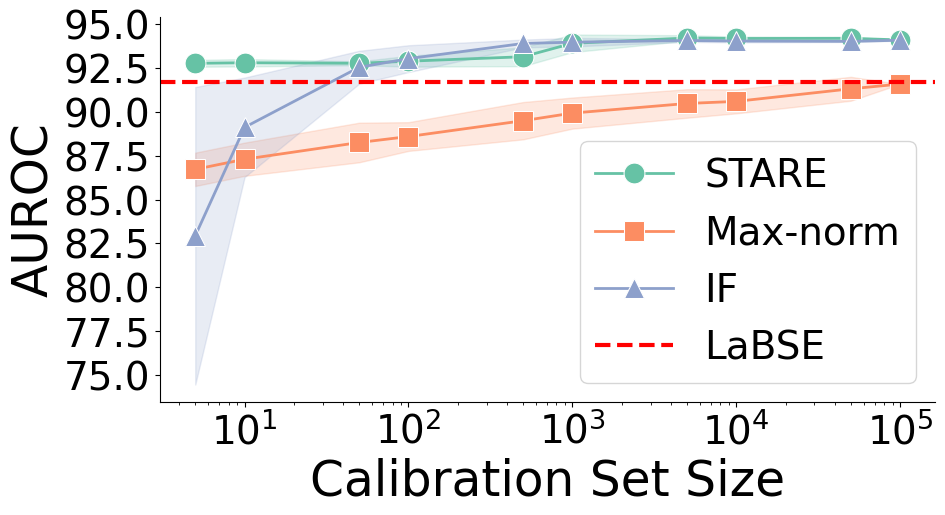

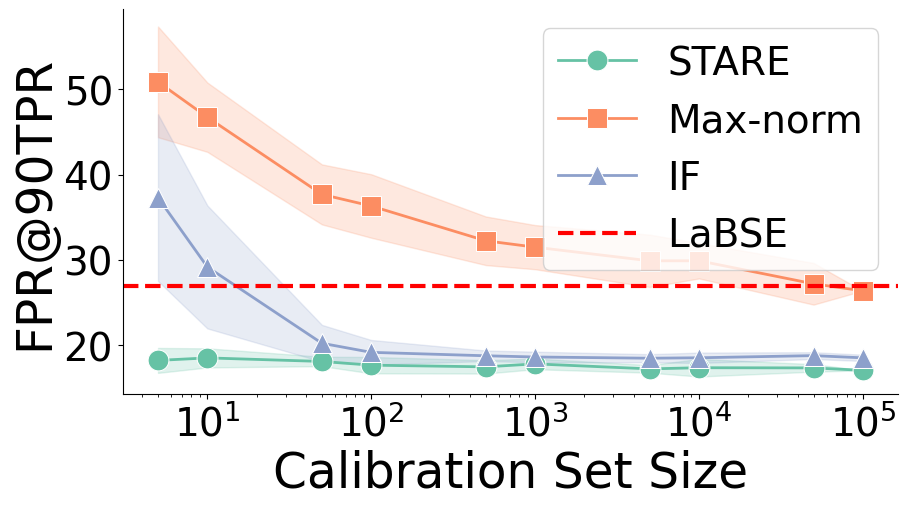

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl 
mpl.rcParams['axes.spines.right'] = False 
mpl.rcParams['axes.spines.top'] = False
sns.set_palette("Set2")

# Plot mean and variance for AUROC
plt.figure(figsize=(10, 5))
sns.lineplot(data=sum_norm_df, x="size", y="auc", estimator="mean", ci="sd", label="STARE", marker="o", linewidth=2, markersize=15)
sns.lineplot(data=max_norm_df, x="size", y="auc", estimator="mean", ci="sd", label="Max-norm", marker="s", linewidth=2, markersize=15)
sns.lineplot(data=IF_df, x="size", y="auc", estimator="mean", ci="sd", label="IF", marker="^", linewidth=2, markersize=15)
plt.xlabel('Calibration Set Size', fontsize=35)
plt.xscale('log')
plt.ylabel('AUROC', fontsize=35)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.axhline(y=91.7, color='r', linestyle='--', label="LaBSE", linewidth=3)
plt.legend(title=None, fontsize=28, loc='best')


# plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot mean and variance for FPR@90TPR
plt.figure(figsize=(10, 5))
sns.lineplot(data=sum_norm_df, x="size", y="fp", estimator="mean", ci="sd", label="STARE", marker="o",markersize=15,linewidth=2)
sns.lineplot(data=max_norm_df, x="size", y="fp", estimator="mean", ci="sd", label="Max-norm", marker="s",markersize=15,linewidth=2)
sns.lineplot(data=IF_df, x="size", y="fp", estimator="mean", ci="sd", label="IF", marker="^",markersize=15,linewidth=2)
plt.xlabel('Calibration Set Size', fontsize=35)
plt.xscale('log')
plt.ylabel('FPR@90TPR', fontsize=35)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.axhline(y=26.9, color='r', linestyle='--', label="LaBSE", linewidth=3)
plt.legend(title=None, fontsize=28, loc='best')


# plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

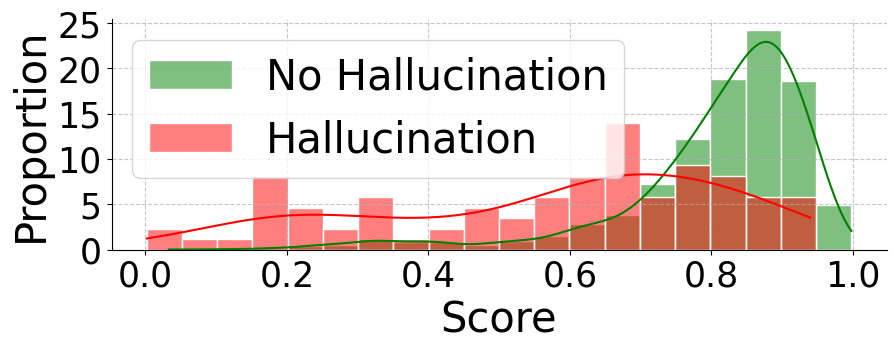

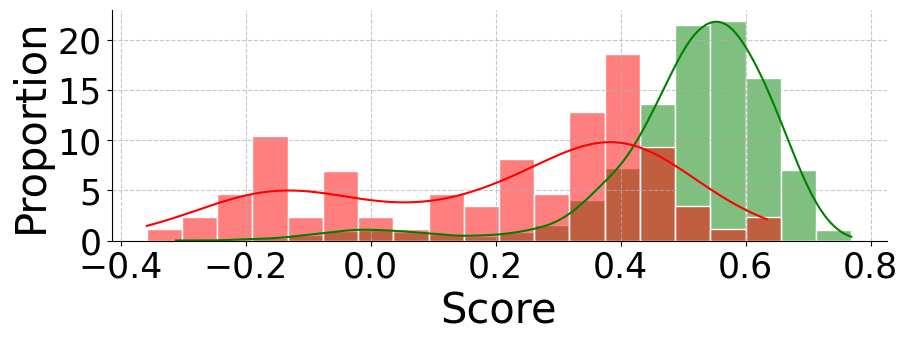

In [14]:
m_to_plot = "labse"
ood = "is_osc"
i = 0

# Filter the data where is_osc is False
# is_osc_false = data_df_testset['is_osc'] == 0
is_osc_false = data_df_testset['is_osc'] <=1
# Plot the prediction for is_osc=False points
plot_prediction(results_full[ood][m_to_plot][i]["pred"][is_osc_false], data_df_testset[ood][is_osc_false].values, "", results_full[ood][m_to_plot][i]["thr"], nbins=20,legend=True)

m_to_plot = "Sum_norm_all"

# Plot the prediction for is_osc=False points with modified values
plot_prediction(results_full[ood][m_to_plot][i]["pred"][is_osc_false] / 5, data_df_testset[ood][is_osc_false].values, "", results_full[ood][m_to_plot][i]["thr"] / 5, nbins=20,legend=False)


In [15]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

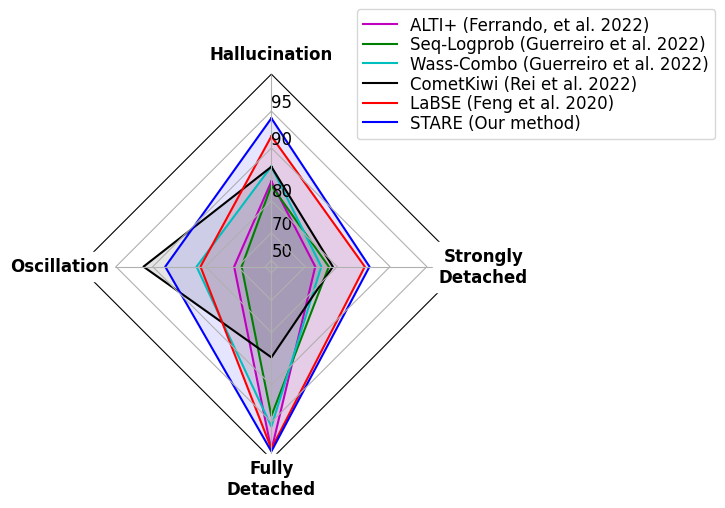

In [16]:
from matplotlib import cm
N = len(oods)
theta = radar_factory(N, frame='polygon')
spoke_labels = oods

method_name_mapping = {
    'alti':"ALTI+ (Ferrando, et al. 2022)",
    "seqlogprob":"Seq-Logprob (Guerreiro et al. 2022)",
    "wass_combo":"Wass-Combo (Guerreiro et al. 2022)",
    "cometkiwi":"CometKiwi (Rei et al. 2022)",
    "labse":"LaBSE (Feng et al. 2020)",
    "Sum_norm_all":"STARE (Our method)"
}

dataset_to_label = {
    "is_hall":"Hallucination",
    "is_osc":"Oscillation",
    "is_fd":"Fully\nDetached",
    "is_sd":"Strongly\nDetached"
}



fig, axs = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection='radar'))

num_colors = len(method_name_mapping)
# colors = cm.get_cmap('tab20', num_colors)
colors = ['m', 'g', 'c', 'k', 'r', 'b']
data = []
for ood in oods:
    data.append([results_full[ood][metric][0]["auc"] for metric in method_name_mapping])

# Transpose data
data = np.array(data).T
def zooming_function(x):
    # Define the power factor (you can adjust this based on the desired zooming effect)
    power_factor = 5.0
    
    # Apply the power function to zoom in on the higher range (50 to 100)
    return x**power_factor
data_zoomed = zooming_function(data)

# Plot
# axs.set_title("Logarithmic Radar Plot", weight='bold', size='medium', position=(0.5, 1.1),
#               horizontalalignment='center', verticalalignment='center')

for i, d in enumerate(data_zoomed):
    # color = colors(i / num_colors)  # Get color from colormap
    color = colors[i]
    axs.plot(theta, d, color=color)
    axs.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')
axs.set_varlabels([dataset_to_label[ood] for ood in spoke_labels])
for label in axs.get_xticklabels():
    label.set_fontsize('large')  # Adjust font size
    label.set_weight('bold')  # Add bold style
    label.set_color('black')  # Change font color
    label.set_backgroundcolor('white')  # Add white background to labels

# Add legend (metric names)
labels = [method_name_mapping[metric] for metric in method_name_mapping]
legend = axs.legend(labels, loc='center left', bbox_to_anchor=(0.7, 1), labelspacing=0.1, fontsize='large')  # Move legend outside to the left
# fig.text(0.5, 0.965, 'Logarithmic 5-Factor Solution Profiles Across Four Scenarios',
#          horizontalalignment='center', color='black', weight='bold', size='large')
axs.set_rgrids([zooming_function(val) for val in [50,70,80,90,95]], labels=['50','70','80','90','95'], angle=0)
for label in axs.get_yticklabels():
    label.set_fontsize('large')
axs.set_axisbelow(False)  # <-- added
plt.show()